<a href="https://colab.research.google.com/github/Abdallhss/Reinformcent-Learning-USM/blob/main/DDPG_USM_No_Temp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [952]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import random

import os
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam


from collections import deque
from tensorflow.keras.layers import Dense

%matplotlib inline

#tf.enable_eager_execution()


In [953]:
tf.version

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.6/dist-packages/tensorflow/_api/v2/version/__init__.py'>

In [954]:
# get the current response given the frequency
class USM_model:
  def __init__(self, opt_freq, min_current, init_freq, min_temp, max_temp, step_size):
    self.opt_freq = opt_freq
    self.min_current = min_current
    self.freq = init_freq
    self.min_temp = min_temp
    self.max_temp = max_temp
    self.temp = min_temp
    self.step_size = step_size

  def USM_current(self,freq):
    dT = self.temp - self.min_temp
    return self.min_current + 50*np.square(freq-np.multiply(self.opt_freq,(1-0.1*dT/self.min_temp)))
  
  def take_action(self,action):
    if action == 0:
      self.freq += self.step_size
    elif action == 1:
      self.freq -= self.step_size

  def step(self,action):
    self.freq += action
    return self.freq, self.USM_current(self.freq)
  
  def set_freq(self,f):
    self.freq = f
  def get_freq(self):
    return self.freq
  def set_step_size(self,step):
    self.step_size = step 
  def get_step_size(self):
    return self.step_size
  def set_temp(self,temp):
    self.temp = temp
  
  def step_temp(self,step):
    new_temp = self.temp + step
    if new_temp < self.min_temp:
      new_temp = self.min_temp
    elif new_temp > self.max_temp:
      new_temp = self.max_temp
    self.temp = new_temp
    


  def get_temp(self):
    return self.temp


In [955]:
min_current = 100
min_temp = 35
max_temp = 40
opt_freq = 40
initial_freq = 41
freq_step = 0.01
USM = USM_model(opt_freq, min_current, initial_freq, min_temp, max_temp, freq_step)

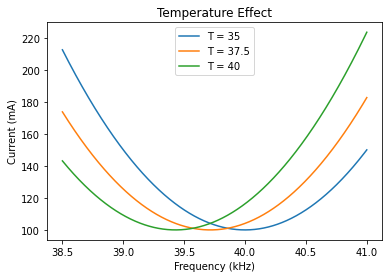

In [956]:
freqs = np.linspace(38.5,41,1000,dtype=np.float32)
USM.set_temp(35)
currents_35 = np.array(USM.USM_current(freqs))
USM.set_temp(37.5)
currents_37_5 = np.array(USM.USM_current(freqs))
USM.set_temp(40)
currents_40 = np.array(USM.USM_current(freqs))
plt.plot(freqs, currents_35, label='T = 35')
plt.plot(freqs, currents_37_5, label='T = 37.5')
plt.plot(freqs, currents_40, label='T = 40')


plt.legend(loc='best')
plt.xlabel("Frequency (kHz)");
plt.ylabel("Current (mA)");
plt.title("Temperature Effect");
plt.show()

In [957]:
# create freq scaler
scaler_freq = StandardScaler()
freqs = np.linspace(39,41,1000,dtype=np.float32).reshape(-1, 1)
scaler_freq.fit(freqs);

# create temp scaler
scaler_temp = StandardScaler()
temps = np.linspace(30,50,1000,dtype=np.float32).reshape(-1, 1)
scaler_temp.fit(temps);

scaler_reward = StandardScaler()
USM.set_temp(35)
currents = np.array(USM.USM_current(freqs))
scaler_reward.fit(currents);

In [958]:
class ReplayBuffer:
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape))
        self.new_state_memory = np.zeros((self.mem_size, *input_shape))
        self.action_memory = np.zeros((self.mem_size, n_actions))
        self.reward_memory = np.zeros(self.mem_size)

    def store_transition(self, state, action, reward, state_):
        index = self.mem_cntr % self.mem_size

        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward

        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, batch_size, replace=False)

        states = self.state_memory[batch]
        states_ = self.new_state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]

        return states, actions, rewards, states_

In [959]:
class Agent:
    def __init__(self, input_dims, alpha=0.0002, beta=0.001, env=None,
            gamma=0, n_actions=1, max_size=2000, tau=0.999, 
            fc1=64, fc2=32, batch_size=32, noise=0.1):
        self.gamma = gamma
        self.tau = tau
        self.memory = ReplayBuffer(max_size, input_dims, n_actions)
        self.batch_size = batch_size
        self.n_actions = n_actions
        self.noise = noise
        self.max_action = 0.5
        self.min_action = -0.5
        
        self.actor = ActorNetwork(fc1_dims=fc1, fc2_dims=fc2,name='actor')
        self.critic = CriticNetwork(fc1_dims=fc1, fc2_dims=fc2,name='critic')
        self.target_actor = ActorNetwork(fc1_dims=fc1, fc2_dims=fc2,name='target_actor')
        self.target_critic = CriticNetwork(fc1_dims=fc1, fc2_dims=fc2,name='target_critic')

        self.actor.compile(optimizer=Adam(learning_rate=alpha),run_eagerly=True)
        self.critic.compile(optimizer=Adam(learning_rate=beta))
        self.target_actor.compile(optimizer=Adam(learning_rate=alpha))
        self.target_critic.compile(optimizer=Adam(learning_rate=beta))

        self.update_network_parameters(tau=1)

    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        weights = []
        targets = self.target_actor.weights
        for i, weight in enumerate(self.actor.weights):
            weights.append(weight * tau + targets[i]*(1-tau))
        self.target_actor.set_weights(weights)

        weights = []
        targets = self.target_critic.weights
        for i, weight in enumerate(self.critic.weights):
            weights.append(weight * tau + targets[i]*(1-tau))
        self.target_critic.set_weights(weights)

    def remember(self, state, action, reward, new_state):
        self.memory.store_transition(state, action, reward, new_state)

    def save_models(self):
        print('... saving models ...')
        self.actor.save_weights(self.actor.checkpoint_file)
        self.target_actor.save_weights(self.target_actor.checkpoint_file)
        self.critic.save_weights(self.critic.checkpoint_file)
        self.target_critic.save_weights(self.target_critic.checkpoint_file)

    def load_models(self):
        print('... loading models ...')
        self.actor.load_weights(self.actor.checkpoint_file)
        self.target_actor.load_weights(self.target_actor.checkpoint_file)
        self.critic.load_weights(self.critic.checkpoint_file)
        self.target_critic.load_weights(self.target_critic.checkpoint_file)

    def choose_action(self, observation, evaluate=False):
        state = tf.convert_to_tensor(observation, dtype=tf.float32)
        actions = self.actor(state)
        if not evaluate:
            actions += tf.random.normal(shape=[self.n_actions],
                    mean=0.0, stddev=self.noise)
        # note that if the environment has an action > 1, we have to multiply by
        # max action at some point
        actions = tf.clip_by_value(actions, self.min_action, self.max_action)

        return actions[0]

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return

        state, action, reward, new_state = \
                self.memory.sample_buffer(self.batch_size)

        states = tf.convert_to_tensor(state, dtype=tf.float32)
        states_ = tf.convert_to_tensor(new_state, dtype=tf.float32)
        rewards = tf.convert_to_tensor(reward, dtype=tf.float32)
        actions = tf.convert_to_tensor(action, dtype=tf.float32)

        with tf.GradientTape() as tape:
            target_actions = self.target_actor(states_)
            critic_value_ = tf.squeeze(self.target_critic(
                                states_, target_actions), 1)
            critic_value = tf.squeeze(self.critic(states, actions), 1)
            target = reward + self.gamma*critic_value_
            critic_loss = keras.losses.MSE(target, critic_value)

        critic_network_gradient = tape.gradient(critic_loss,
                                            self.critic.trainable_variables)
        self.critic.optimizer.apply_gradients(zip(
            critic_network_gradient, self.critic.trainable_variables))

        with tf.GradientTape() as tape:
            new_policy_actions = self.actor(states)
            actor_loss = -self.critic(states, new_policy_actions)
            actor_loss = tf.math.reduce_mean(actor_loss)

        actor_network_gradient = tape.gradient(actor_loss, 
                                    self.actor.trainable_variables)
        self.actor.optimizer.apply_gradients(zip(
            actor_network_gradient, self.actor.trainable_variables))

        self.update_network_parameters()
        

In [960]:
class CriticNetwork(keras.Model):
    def __init__(self, fc1_dims=64, fc2_dims=32,
            name='critic', chkpt_dir='tmp/ddpg'):
        super(CriticNetwork, self).__init__()
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims

        self.model_name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, 
                    self.model_name+'_ddpg.h5')

        self.fc1 = Dense(self.fc1_dims, activation='relu')
        self.fc2 = Dense(self.fc2_dims, activation='relu')
        self.q = Dense(1, activation=None)

    def call(self, state, action):
        action_value = self.fc1(tf.concat([state, action], axis=1))
        action_value = self.fc2(action_value)

        q = self.q(action_value)

        return q

class ActorNetwork(keras.Model):
    def __init__(self, fc1_dims=64, fc2_dims=32, n_actions=1, name='actor',
            chkpt_dir='tmp/ddpg'):
        super(ActorNetwork, self).__init__()
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions

        self.model_name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, 
                    self.model_name+'_ddpg.h5')

        self.fc1 = Dense(self.fc1_dims, activation='relu')
        self.fc2 = Dense(self.fc2_dims, activation='relu')
        self.mu = Dense(self.n_actions, activation='tanh')

    def call(self, state):
        prob = self.fc1(state)
        prob = self.fc2(prob)

        mu = self.mu(prob)

        return mu

In [961]:
def plot_learning_curve(x, scores, figure_file):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 100 scores')
    plt.savefig(figure_file)

Step: 0 -- freq: [40.908535] -- reward: 141.27178955078125
Step: 100 -- freq: [40.064217] -- reward: 103.69268798828125
Step: 200 -- freq: [39.425148] -- reward: 106.89152526855469
Step: 300 -- freq: [40.033573] -- reward: 104.96180725097656
Step: 400 -- freq: [39.967926] -- reward: 101.38482666015625
Step: 500 -- freq: [39.95696] -- reward: 100.513916015625
Step: 600 -- freq: [40.053177] -- reward: 100.49445343017578
Step: 700 -- freq: [40.2269] -- reward: 100.40022277832031
Step: 800 -- freq: [40.07801] -- reward: 100.5412826538086
Step: 900 -- freq: [39.979904] -- reward: 100.52039337158203
episode  0 score 102031.4 avg score 102031.4
tf.Tensor([40.021473], shape=(1,), dtype=float32)


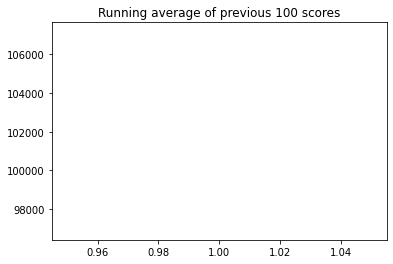

In [971]:
#agent = Agent(input_dims= [1], n_actions=1,alpha=0.0002, beta=0.001,
#            gamma=0, max_size=200, tau=0.999, 
#            fc1=64, fc2=32, batch_size=64, noise=0.1)
random.seed(2)
agent = Agent(input_dims= [1], n_actions=1,alpha=0.0007, beta=0.001,
            gamma=0, max_size=200, tau=0.999, 
            fc1=64, fc2=32, batch_size=64, noise=0.1)
n_games = 1
n_steps = 1000
figure_file = 'USM.png'

best_score = -np.inf
score_history = []
train_actions = []
train_states = []
train_rewards = []
train_steps = []
train_temps = []
load_checkpoint = False
mean_reward = 0
evaluate = False
USM.set_temp(35)
for i in range(n_games):
    USM.set_freq(41)#38+round(random.random(),1)*4
    observation = USM.get_freq()
    observation = (scaler_freq.transform(np.array(observation).reshape(-1,1))).squeeze()
    observation = np.reshape(observation, [1,1])
    score = 0
    for step in range(n_steps):
        action = agent.choose_action(observation, evaluate)
        observation_, reward = USM.step(action)


        train_steps.append(step)
        train_rewards.append(reward)
        train_actions.append(action)
        train_states.append(observation_)


        observation_ = scaler_freq.transform(np.array(observation_).reshape(-1,1))
        
        score += reward

        mean_reward = mean_reward + (reward-mean_reward)/(step+1)  

        reward = scaler_reward.transform(np.array(reward).reshape(-1,1))
        agent.remember(observation, action, -reward, observation_)
        agent.learn()
        observation = observation_
        
        if (step % 100) == 0:
          print("Step: {} -- freq: {} -- reward: {}".format(step,USM.get_freq(), np.mean(train_rewards[-100:])))

    score_history.append(score)
    avg_score = np.mean(score_history[-100:])

    if avg_score > best_score:
        best_score = avg_score
        #agent.save_models()

    print('episode ', i, 'score %.1f' % score, 'avg score %.1f' % avg_score)
    print(USM.get_freq())
if not load_checkpoint:
    x = [i+1 for i in range(n_games)]
    plot_learning_curve(x, score_history, figure_file)

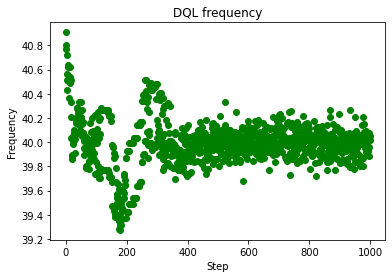

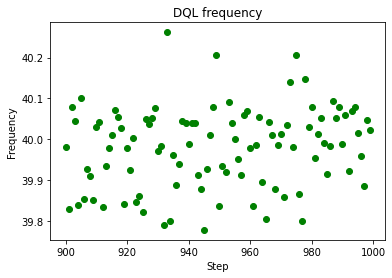

In [972]:
states_40 = np.array(train_states).squeeze()
plt.plot(train_steps, states_40, 'go', label='True data')
plt.xlabel("Step");
plt.ylabel("Frequency");
plt.title("DQL frequency");
plt.show()
plt.plot(train_steps[-100:], states_40[-100:], 'go', label='True data')
plt.xlabel("Step");
plt.ylabel("Frequency");
plt.title("DQL frequency");
plt.show()

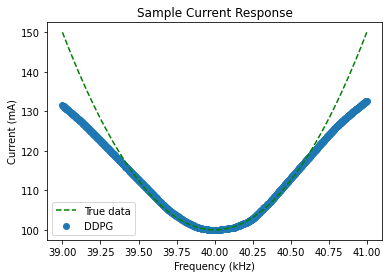

In [973]:
freqs = np.linspace(39,41,1000,dtype=np.float32).reshape(-1, 1)
USM.set_temp(35)
currents = np.array(USM.USM_current(freqs))
actions = np.repeat([0],1000).reshape(-1,1)

freqs_t = scaler_freq.transform(freqs)
predicted = -np.squeeze(agent.critic(freqs_t, actions), 1)

predicted = scaler_reward.inverse_transform(predicted)
plt.plot(freqs, currents, 'g--', label='True data')
plt.scatter(freqs, predicted, label='DDPG')

plt.legend(loc='best')
plt.xlabel("Frequency (kHz)");
plt.ylabel("Current (mA)");
plt.title("Sample Current Response");
plt.show()

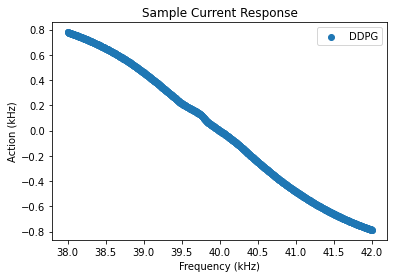

In [983]:
freqs = np.linspace(38,42,1000,dtype=np.float32).reshape(-1, 1)
USM.set_temp(35)
currents = np.array(USM.USM_current(freqs))
actions = np.repeat([0],1000).reshape(-1,1)


predicted = np.squeeze(agent.actor(freqs_t), 1)

#predicted = -scaler_reward.inverse_transform(predicted)
#plt.plot(freqs, currents, 'g--', label='True data')
plt.scatter(freqs, predicted, label='DDPG')

plt.legend(loc='best')
plt.xlabel("Frequency (kHz)");
plt.ylabel("Action (kHz)");
plt.title("Sample Current Response");
plt.show()

In [989]:
USM.set_freq(41)#38+round(random.random(),1)*4
USM.set_temp(35)
observation = USM.get_freq()
observation = scaler_freq.transform(np.array(observation).reshape(-1,1))
actions = []
states = []
rewards = []
steps = []
for i in range (1000):
  action = agent.choose_action(observation,True)
  # Advance the game to the next frame based on the action.
  # Reward is 1 for every frame the pole survived
  next_freq, reward = USM.step(action)
  states.append(next_freq)
  observation = scaler_freq.transform(np.array(next_freq).reshape(-1,1))
  steps.append(i)
  rewards.append(reward)
  actions.append(action)


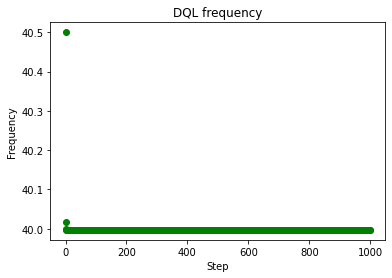

In [990]:
states_40 = np.array(states).squeeze()
plt.plot(steps, states_40, 'go', label='True data')
plt.xlabel("Step");
plt.ylabel("Frequency");
plt.title("DQL frequency");
plt.show()


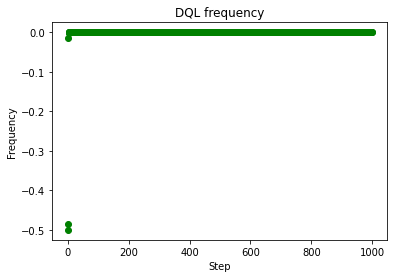

In [991]:
actions_40 = np.array(actions).squeeze()
plt.plot(steps, actions_40, 'go', label='True data')
plt.xlabel("Step");
plt.ylabel("Frequency");
plt.title("DQL frequency");
plt.show()

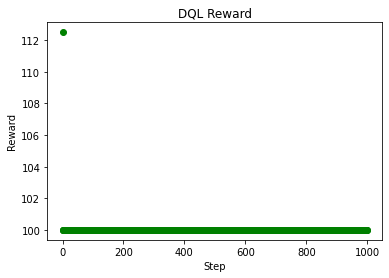

In [992]:
rewards_40 = np.array(rewards).squeeze()
plt.plot(steps, rewards_40, 'go', label='True data')
plt.xlabel("Step");
plt.ylabel("Reward");
plt.title("DQL Reward");
plt.show()



In [993]:
USM.get_freq()

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([39.997128], dtype=float32)>